# Introduction

This notebook explores building ML algorithms to fine tune the Spotify track recommendations (based on selected playlists) and then auto create a new playlist and feed the selected recommended tracks to your Spotify libaray. 

We will be using the following techniques to build the algorithms:
  - calculating similarity scores (based on audio features) between recommended tracks and the tracks in the selected playlists and then filtering the most similar trarcks
  - filtering the tracks again to ensure the audio features and popularity of tracks is greater than the average of the tracks in the playlist
  - removing duplicate tracks of the exiting playlists
  - creating new playlist in my Spotify with the final tracks

# Import the packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from datetime import datetime, timedelta, date

In [36]:
# client credentials
c_id = 'xxxxxxxxxx'
secret = 'xxxxxxxxxx'
uri = 'xxxxxxxxxx'
user_name = 'xxxxxxxxxx'

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load data

In [3]:
followed_artists_df = pd.read_csv("/Users/Lawrence/Desktop/spotify_data/followed_artists.csv")
top_artists_df = pd.read_csv("/Users/Lawrence/Desktop/spotify_data/top_artists.csv")
top_tracks_df = pd.read_csv("/Users/Lawrence/Desktop/spotify_data/top_tracks.csv")
followed_playlists_df = pd.read_csv("/Users/Lawrence/Desktop/spotify_data/followed_playlists_tracks.csv")
initial_rec_tracks_df = pd.read_csv("/Users/Lawrence/Desktop/spotify_data/recommended_tracks.csv")

# Get a high level overview of the data

In [4]:
# first of all, let's look at the selected playlist df
followed_playlists_df.head()

,id,name,popularity,type_x,is_local,explicit,duration_ms_x,disc_number,track_number,artist_id,artist_name,album_artist_id,album_artist_name,album_id,album_name,album_release_date,album_type,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type_y,uri,track_href,analysis_url,duration_ms_y,time_signature,genres,album_genres
0,7sjwaBQ6M3aVigYfBjm1sL,Ima Boss (feat. Rick Ross),66,track,False,True,250240,1,9,20sxb77xiYeusSH8cVdatc,Meek Mill,0LyfQWJT6nXafLPZqxe9Of,Various Artists,1xE3Obhzdpw4aIqPDMf4I4,"MMG Presents: Self Made, Vol. 1",2011-05-23,album,0.370,0.870,5,-2.090,1,0.2710,0.04150,0.0,0.604,0.3310,79.092,audio_features,spotify:track:7sjwaBQ6M3aVigYfBjm1sL,https://api.spotify.com/v1/tracks/7sjwaBQ6M3aV...,https://api.spotify.com/v1/audio-analysis/7sjw...,250240,4,"['hip hop', 'philly rap', 'pop rap', 'rap', 's...",[]
1,1D3z6HTiQsNmZxjl7F7eoG,m y . l i f e (with 21 Savage & Morray),83,track,False,True,218801,1,3,6l3HvQ5sa6mXTsMTB19rO5,J. Cole,6l3HvQ5sa6mXTsMTB19rO5,J. Cole,4JAvwK4APPArjIsOdGoJXX,The Off-Season,2021-05-14,album,0.597,0.587,7,-7.026,0,0.1370,0.06220,0.0,0.214,0.0753,140.021,audio_features,spotify:track:1D3z6HTiQsNmZxjl7F7eoG,https://api.spotify.com/v1/tracks/1D3z6HTiQsNm...,https://api.spotify.com/v1/audio-analysis/1D3z...,218802,4,"['conscious hip hop', 'hip hop', 'north caroli...","['conscious hip hop', 'hip hop', 'north caroli..."
2,1t9WgS8FN0534tLBRwbaxO,Whoopty,76,track,False,True,123262,1,4,7arQA31aZVS8yS6zUveWzb,CJ,7arQA31aZVS8yS6zUveWzb,CJ,0kHRftVXaiRHgQdtviml0G,Loyalty Over Royalty,2021-02-19,album,0.719,0.648,3,-7.600,0,0.1250,0.20000,0.0,0.127,0.6600,140.201,audio_features,spotify:track:1t9WgS8FN0534tLBRwbaxO,https://api.spotify.com/v1/tracks/1t9WgS8FN053...,https://api.spotify.com/v1/audio-analysis/1t9W...,123263,4,['nyc rap'],['nyc rap']
3,20GrahbI4AzAOWxpYfDKkf,"I DID IT (feat. Post Malone, Megan Thee Stalli...",76,track,False,True,165366,1,5,0QHgL1lAIqAw0HtD7YldmP,DJ Khaled,0QHgL1lAIqAw0HtD7YldmP,DJ Khaled,5kE2OAuUYGBqqzscqgBXXf,KHALED KHALED,2021-04-30,album,0.757,0.721,4,-2.906,0,0.0691,0.00196,0.0,0.647,0.3640,124.036,audio_features,spotify:track:20GrahbI4AzAOWxpYfDKkf,https://api.spotify.com/v1/tracks/20GrahbI4AzA...,https://api.spotify.com/v1/audio-analysis/20Gr...,165366,4,"['hip hop', 'miami hip hop', 'pop rap', 'rap',...","['hip hop', 'miami hip hop', 'pop rap', 'rap',..."
4,5JxNTXVY55RAYnPmnaBJzJ,Levels To This,29,track,False,True,192026,1,1,0GPqspWpvbvmfARaIlRKft,Blanco Balling,0GPqspWpvbvmfARaIlRKft,Blanco Balling,6qhCPFgfFQUuLTQ7zPZlse,Levels To This,2021-02-08,album,0.679,0.789,2,-6.863,1,0.2130,0.11800,0.0,0.150,0.4660,150.080,audio_features,spotify:track:5JxNTXVY55RAYnPmnaBJzJ,https://api.spotify.com/v1/tracks/5JxNTXVY55RA...,https://api.spotify.com/v1/audio-analysis/5JxN...,192026,4,[],[]


In [5]:
followed_playlists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  167 non-null    object 
 1   name                167 non-null    object 
 2   popularity          167 non-null    int64  
 3   type_x              167 non-null    object 
 4   is_local            167 non-null    bool   
 5   explicit            167 non-null    bool   
 6   duration_ms_x       167 non-null    int64  
 7   disc_number         167 non-null    int64  
 8   track_number        167 non-null    int64  
 9   artist_id           167 non-null    object 
 10  artist_name         167 non-null    object 
 11  album_artist_id     167 non-null    object 
 12  album_artist_name   167 non-null    object 
 13  album_id            167 non-null    object 
 14  album_name          167 non-null    object 
 15  album_release_date  167 non-null    object 
 16  album_ty

In [6]:
followed_playlists_df.describe()

,popularity,duration_ms_x,disc_number,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms_y,time_signature
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,57.502994,204728.826347,1.005988,4.119760,0.744533,0.660323,5.293413,-6.277898,0.514970,0.209423,0.121756,0.006744,0.209004,0.467160,126.423533,204729.275449,4.005988
std,24.114155,45812.974636,0.077382,4.834368,0.128765,0.135020,3.801254,2.200711,0.501279,0.117766,0.147745,0.045566,0.173991,0.212053,28.205942,45812.967701,0.134299
min,0.000000,108061.000000,1.000000,1.000000,0.330000,0.341000,0.000000,-13.471000,0.000000,0.031700,0.000282,0.000000,0.033200,0.039100,72.791000,108061.000000,3.000000
25%,37.500000,175533.500000,1.000000,1.000000,0.679000,0.570000,2.000000,-7.658000,0.000000,0.104500,0.019950,0.000000,0.101000,0.330000,99.243000,175533.500000,4.000000
50%,67.000000,199578.000000,1.000000,1.000000,0.761000,0.656000,5.000000,-6.193000,1.000000,0.200000,0.064600,0.000000,0.143000,0.462000,130.205000,199579.000000,4.000000
75%,76.000000,228279.500000,1.000000,5.500000,0.838000,0.758000,9.000000,-4.678000,1.000000,0.294000,0.171500,0.000001,0.259000,0.597000,146.114000,228280.500000,4.000000
max,88.000000,343150.000000,2.000000,30.000000,0.950000,0.983000,11.000000,-1.005000,1.000000,0.505000,0.757000,0.497000,0.873000,0.966000,202.006000,343150.000000,5.000000


- poplularity and tempo has large standard deviation
- need to get familiar with the meaning of the audio features of Spotify
- different columns of different scales (e.g. key v.s. energy). need to use scaler to make sure the numeric values have similar scales in order to run ML algo

In [7]:
# let's specifically look at the values of a few columns that are non numeric
obj_cols = ['is_local','explicit','type_x','album_type','type_y','genres','album_genres']

for col in obj_cols:
    print("column is:",col) 
    print(followed_playlists_df[col].value_counts())
    print("-"*10)

column is: is_local
False    167
Name: is_local, dtype: int64
----------
column is: explicit
True     160
False      7
Name: explicit, dtype: int64
----------
column is: type_x
track    167
Name: type_x, dtype: int64
----------
column is: album_type
album    167
Name: album_type, dtype: int64
----------
column is: type_y
audio_features    167
Name: type_y, dtype: int64
----------
column is: genres
[]                                                                                                                                      37
['hip hop', 'philly rap', 'pop rap', 'rap', 'southern hip hop', 'trap']                                                                  6
['dfw rap', 'melodic rap', 'rap']                                                                                                        4
['rap', 'slap house']                                                                                                                    4
['atl hip hop', 'atl trap', 'rap', 'trap'] 

In [8]:
initial_rec_tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1917 non-null   object 
 1   name                1917 non-null   object 
 2   popularity          1917 non-null   int64  
 3   type_x              1917 non-null   object 
 4   is_local            1917 non-null   bool   
 5   explicit            1917 non-null   bool   
 6   duration_ms_x       1917 non-null   int64  
 7   disc_number         1917 non-null   int64  
 8   track_number        1917 non-null   int64  
 9   artist_id           1917 non-null   object 
 10  artist_name         1917 non-null   object 
 11  album_artist_id     1917 non-null   object 
 12  album_artist_name   1917 non-null   object 
 13  album_id            1917 non-null   object 
 14  album_name          1917 non-null   object 
 15  album_release_date  1917 non-null   object 
 16  album_

In [9]:
# Then let's look at the recommended tracks data
initial_rec_tracks_df.head()

,id,name,popularity,type_x,is_local,explicit,duration_ms_x,disc_number,track_number,artist_id,artist_name,album_artist_id,album_artist_name,album_id,album_name,album_release_date,album_type,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type_y,uri,track_href,analysis_url,duration_ms_y,time_signature,genres,album_genres
0,5YEOzOojehCqxGQCcQiyR4,Panda,73,track,False,True,246761,1,14,7pFeBzX627ff0VnN6bxPR4,Desiigner,7pFeBzX627ff0VnN6bxPR4,Desiigner,0cHT4ll3sEPyFFWoFuibMl,New English,2016-06-26,ALBUM,0.576,0.766,10,-4.943,0,0.4490,0.028000,0.000002,0.366,0.236,144.833,audio_features,spotify:track:5YEOzOojehCqxGQCcQiyR4,https://api.spotify.com/v1/tracks/5YEOzOojehCq...,https://api.spotify.com/v1/audio-analysis/5YEO...,246761,4,"['pop rap', 'rap', 'trap', 'viral trap']","['pop rap', 'rap', 'trap', 'viral trap']"
1,3DzlR0kXE6shimFVhSwI4A,Trouble on My Mind,61,track,False,True,212506,1,3,0ONHkAv9pCAFxb0zJwDNTy,Pusha T,0ONHkAv9pCAFxb0zJwDNTy,Pusha T,6ZS2NOEZ7XwlNlKWK2dzPM,Fear of God II: Let Us Pray,2001,ALBUM,0.655,0.794,1,-6.113,0,0.3670,0.093500,0.000036,0.383,0.608,172.106,audio_features,spotify:track:3DzlR0kXE6shimFVhSwI4A,https://api.spotify.com/v1/tracks/3DzlR0kXE6sh...,https://api.spotify.com/v1/audio-analysis/3Dzl...,212507,4,"['gangster rap', 'hip hop', 'pop rap', 'rap', ...","['gangster rap', 'hip hop', 'pop rap', 'rap', ..."
2,1BvTqJLeB9ZeGU01gFzJbh,"Bag of Money (feat. Rick Ross, Meek Mill & T-P...",45,track,False,True,247293,1,1,67nwj3Y5sZQLl72VNUHEYE,Wale,67nwj3Y5sZQLl72VNUHEYE,Wale,4M1WXCpnNqFMmiZz0W3FfW,"Bag of Money (feat. Rick Ross, Meek Mill & T-P...",2012-03-23,SINGLE,0.536,0.560,8,-5.668,1,0.2600,0.037900,0.000000,0.114,0.279,139.910,audio_features,spotify:track:1BvTqJLeB9ZeGU01gFzJbh,https://api.spotify.com/v1/tracks/1BvTqJLeB9Ze...,https://api.spotify.com/v1/audio-analysis/1BvT...,247293,4,"['dance pop', 'gangster rap', 'hip hop', 'pop'...","['dance pop', 'gangster rap', 'hip hop', 'pop'..."
3,7qFxSPDUDMQNGBqTvK4aEj,I Luv It,56,track,False,True,240613,1,5,4yBK75WVCQXej1p04GWqxH,Jeezy,4yBK75WVCQXej1p04GWqxH,Jeezy,4slt7bfeNHSJUOMVtuIdxP,The Inspiration,2006-01-01,ALBUM,0.641,0.765,9,-6.626,1,0.0383,0.000975,0.000000,0.387,0.190,91.009,audio_features,spotify:track:7qFxSPDUDMQNGBqTvK4aEj,https://api.spotify.com/v1/tracks/7qFxSPDUDMQN...,https://api.spotify.com/v1/audio-analysis/7qFx...,240613,4,"['atl hip hop', 'crunk', 'dirty south rap', 'g...","['atl hip hop', 'crunk', 'dirty south rap', 'g..."
4,5WeiB5JDBy6T5QQxtj09zb,Crank That (Soulja Boy) [Travis Barker Remix],54,track,False,False,247013,1,1,6GMYJwaziB4ekv1Y6wCDWS,Soulja Boy,6GMYJwaziB4ekv1Y6wCDWS,Soulja Boy,69DoMDa1QmUvCAoMElNI33,Crank That (Soulja Boy) [Travis Barker Remix],2007-01-01,SINGLE,0.671,0.531,8,-5.551,1,0.0467,0.030700,0.000000,0.365,0.280,140.013,audio_features,spotify:track:5WeiB5JDBy6T5QQxtj09zb,https://api.spotify.com/v1/tracks/5WeiB5JDBy6T...,https://api.spotify.com/v1/audio-analysis/5Wei...,247013,4,"['atl hip hop', 'chicago bop', 'dance pop', 'd...","['atl hip hop', 'chicago bop', 'dance pop', 'd..."


In [10]:
initial_rec_tracks_df.describe()

,popularity,duration_ms_x,disc_number,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms_y,time_signature
count,1917.000000,1917.000000,1917.000000,1917.000000,1917.00000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000
mean,56.495044,206738.707355,1.006781,5.194053,0.73361,0.661235,5.299426,-6.356913,0.531038,0.207204,0.141768,0.017743,0.195427,0.487833,123.502707,206738.179969,3.997392
std,17.490845,53159.448100,0.082091,5.365640,0.13402,0.143974,3.686157,2.309162,0.499166,0.136505,0.169729,0.109547,0.149386,0.214245,29.678827,53158.005869,0.269333
min,0.000000,20817.000000,1.000000,1.000000,0.25000,0.179000,0.000000,-20.142000,0.000000,0.024500,0.000037,0.000000,0.023800,0.037500,52.145000,20817.000000,1.000000
25%,49.000000,170751.000000,1.000000,1.000000,0.64800,0.561000,1.000000,-7.647000,0.000000,0.083700,0.022200,0.000000,0.100000,0.330000,97.992000,170752.000000,4.000000
50%,60.000000,202072.000000,1.000000,3.000000,0.74800,0.662000,6.000000,-6.091000,1.000000,0.193000,0.073900,0.000000,0.133000,0.484000,125.978000,202072.000000,4.000000
75%,68.000000,237506.000000,1.000000,7.000000,0.83700,0.765000,8.000000,-4.833000,1.000000,0.300000,0.197000,0.000003,0.255000,0.649000,144.067000,237507.000000,4.000000
max,90.000000,530253.000000,2.000000,89.000000,0.97400,0.997000,11.000000,0.175000,1.000000,0.946000,0.866000,0.954000,0.960000,0.977000,249.438000,530253.000000,5.000000


In [11]:
for col in obj_cols:
    print("column is:",col) 
    print(initial_rec_tracks_df[col].value_counts())
    print("-"*10)

column is: is_local
False    1917
Name: is_local, dtype: int64
----------
column is: explicit
True     1651
False     266
Name: explicit, dtype: int64
----------
column is: type_x
track    1917
Name: type_x, dtype: int64
----------
column is: album_type
ALBUM          1263
SINGLE          629
COMPILATION      25
Name: album_type, dtype: int64
----------
column is: type_y
audio_features    1917
Name: type_y, dtype: int64
----------
column is: genres
[]                                                                                                                                                                                            123
['dance pop', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']                                                                                                                         40
['gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']                                                                                      

# Data Manipulation (Feature engineering)

In [12]:
# removing unenecessary columns from the dfs
cols_needed = followed_playlists_df.columns.values.tolist()
cols_needed = [e for e in cols_needed if e not in ('type_x','is_local','duration_ms_x','disc_number',\
                                                         'track_number','album_artist_id','album_id','album_name',\
                                                         'album_artist_name','album_type','type_y','uri',\
                                                         'track_href','analysis_url','duration_ms_y','album_genres')]
print(cols_needed)

['id', 'name', 'popularity', 'explicit', 'artist_id', 'artist_name', 'album_release_date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'genres']


In [13]:
tracks_selected_playlists_df = followed_playlists_df.copy()[cols_needed]
tracks_recommended_df = initial_rec_tracks_df.copy()[cols_needed]
print(tracks_selected_playlists_df.head())
print("-"*100)
print(tracks_recommended_df.head())

                       id                                               name  \
0  7sjwaBQ6M3aVigYfBjm1sL                         Ima Boss (feat. Rick Ross)   
1  1D3z6HTiQsNmZxjl7F7eoG            m y . l i f e (with 21 Savage & Morray)   
2  1t9WgS8FN0534tLBRwbaxO                                            Whoopty   
3  20GrahbI4AzAOWxpYfDKkf  I DID IT (feat. Post Malone, Megan Thee Stalli...   
4  5JxNTXVY55RAYnPmnaBJzJ                                     Levels To This   

   popularity  explicit               artist_id     artist_name  \
0          66      True  20sxb77xiYeusSH8cVdatc       Meek Mill   
1          83      True  6l3HvQ5sa6mXTsMTB19rO5         J. Cole   
2          76      True  7arQA31aZVS8yS6zUveWzb              CJ   
3          76      True  0QHgL1lAIqAw0HtD7YldmP       DJ Khaled   
4          29      True  0GPqspWpvbvmfARaIlRKft  Blanco Balling   

  album_release_date  danceability  energy  key  loudness  mode  speechiness  \
0         2011-05-23         0.370  

In [14]:
raw_dfs = [tracks_selected_playlists_df,tracks_recommended_df]

for df in raw_dfs:
    df['release_days_diff'] = 0   # create a new column for days after the track has been released
    df['explicit'] = df['explicit'].apply(lambda x: 1 if x == True else 0)   #convert boolean values to numeric values
    
    # transform 'album_release_date' from strings to datetime and calculate the time difference
    for idx in df.index:
        if len(df['album_release_date'][idx].split('-')) == 1:
            df['album_release_date'][idx] = df['album_release_date'][idx]+"-01-01"
        else:
            pass
        df['album_release_date'][idx] = datetime.strptime(df['album_release_date'][idx],'%Y-%m-%d')
        df['release_days_diff'][idx] = (datetime.today()- df['album_release_date'][idx]).days
    

/Users/Lawrence/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/Lawrence/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Lawrence/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path w

In [15]:
tracks_selected_playlists_df.head(3)

,id,name,popularity,explicit,artist_id,artist_name,album_release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genres,release_days_diff
0,7sjwaBQ6M3aVigYfBjm1sL,Ima Boss (feat. Rick Ross),66,1,20sxb77xiYeusSH8cVdatc,Meek Mill,2011-05-23 00:00:00,0.370,0.870,5,-2.090,1,0.271,0.0415,0.0,0.604,0.3310,79.092,4,"['hip hop', 'philly rap', 'pop rap', 'rap', 's...",3734
1,1D3z6HTiQsNmZxjl7F7eoG,m y . l i f e (with 21 Savage & Morray),83,1,6l3HvQ5sa6mXTsMTB19rO5,J. Cole,2021-05-14 00:00:00,0.597,0.587,7,-7.026,0,0.137,0.0622,0.0,0.214,0.0753,140.021,4,"['conscious hip hop', 'hip hop', 'north caroli...",90
2,1t9WgS8FN0534tLBRwbaxO,Whoopty,76,1,7arQA31aZVS8yS6zUveWzb,CJ,2021-02-19 00:00:00,0.719,0.648,3,-7.600,0,0.125,0.2000,0.0,0.127,0.6600,140.201,4,['nyc rap'],174


In [16]:
tracks_recommended_df.head(3)

,id,name,popularity,explicit,artist_id,artist_name,album_release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genres,release_days_diff
0,5YEOzOojehCqxGQCcQiyR4,Panda,73,1,7pFeBzX627ff0VnN6bxPR4,Desiigner,2016-06-26 00:00:00,0.576,0.766,10,-4.943,0,0.449,0.0280,0.000002,0.366,0.236,144.833,4,"['pop rap', 'rap', 'trap', 'viral trap']",1873
1,3DzlR0kXE6shimFVhSwI4A,Trouble on My Mind,61,1,0ONHkAv9pCAFxb0zJwDNTy,Pusha T,2001-01-01 00:00:00,0.655,0.794,1,-6.113,0,0.367,0.0935,0.000036,0.383,0.608,172.106,4,"['gangster rap', 'hip hop', 'pop rap', 'rap', ...",7528
2,1BvTqJLeB9ZeGU01gFzJbh,"Bag of Money (feat. Rick Ross, Meek Mill & T-P...",45,1,67nwj3Y5sZQLl72VNUHEYE,Wale,2012-03-23 00:00:00,0.536,0.560,8,-5.668,1,0.260,0.0379,0.000000,0.114,0.279,139.910,4,"['dance pop', 'gangster rap', 'hip hop', 'pop'...",3429


# Exploratory Data Analysis (EDA)

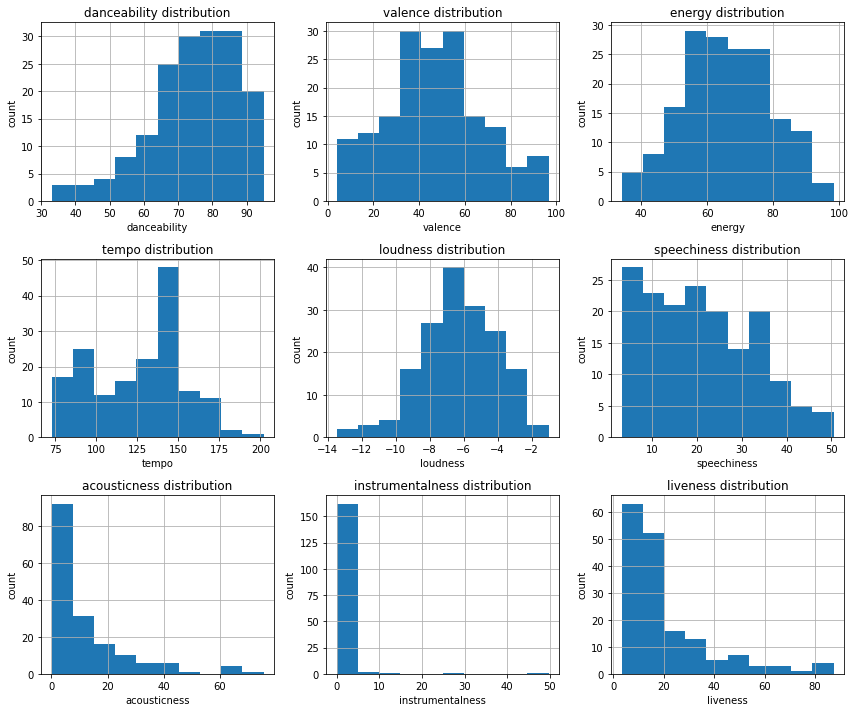

In [17]:
audio_features = ['danceability', 'valence','energy', 'tempo','loudness', 'speechiness',\
                  'acousticness', 'instrumentalness', 'liveness', 'mode','key','time_signature']

df = tracks_selected_playlists_df.loc[:,audio_features[0:9]]

for feature in df.columns:
    if feature == 'tempo' or feature == 'loudness':
        continue
    df[feature] = df[feature] * 100

# let's look at the features that have continuous values first
fig = plt.figure(figsize=(12,10))
columns = 3
rows = 3

for i, feature in zip(range(1, 10), audio_features):
    fig.add_subplot(rows, columns, i)
    plt.hist(df[feature])
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.title('{feature} distribution'.format(feature=feature))
    plt.grid(True)

fig.tight_layout()
plt.show()

From the above histograms, we can see:
   - the tracks in the playlist are dancible, energetic and positive and have strong tempo.
   - the tracks tend to be very vocal and speechy
   - based on the above characteristics, I guess most of them are rap music

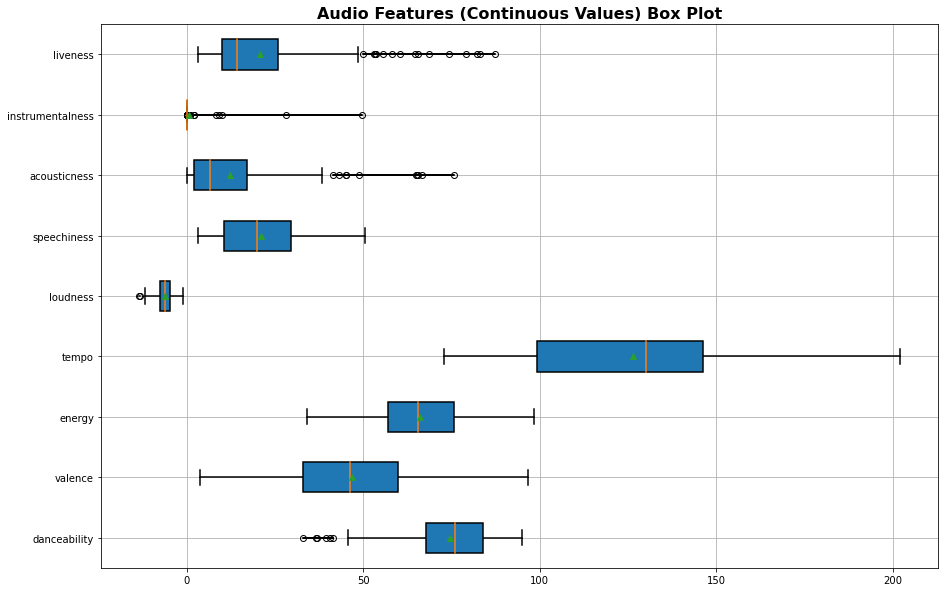

In [18]:
# let's look at the boxplots of the above features to analyze their distributions in a more detailed way

df.boxplot(column=df.columns.values.tolist(), vert = False, figsize = (15,10),\
                                     showfliers = True, showmeans = True, 
                                     patch_artist=True, boxprops=dict(linestyle='-', linewidth=1.5),
                                     flierprops=dict(linestyle='-', linewidth=1.5),
                                     medianprops=dict(linestyle='-', linewidth=1.5),
                                     whiskerprops=dict(linestyle='-', linewidth=1.5),
                                     capprops=dict(linestyle='-', linewidth=1.5))

plt.title("Audio Features (Continuous Values) Box Plot", fontsize=16, fontweight='heavy')
plt.show()

<AxesSubplot:title={'center':'Averages of Audio Features'}>

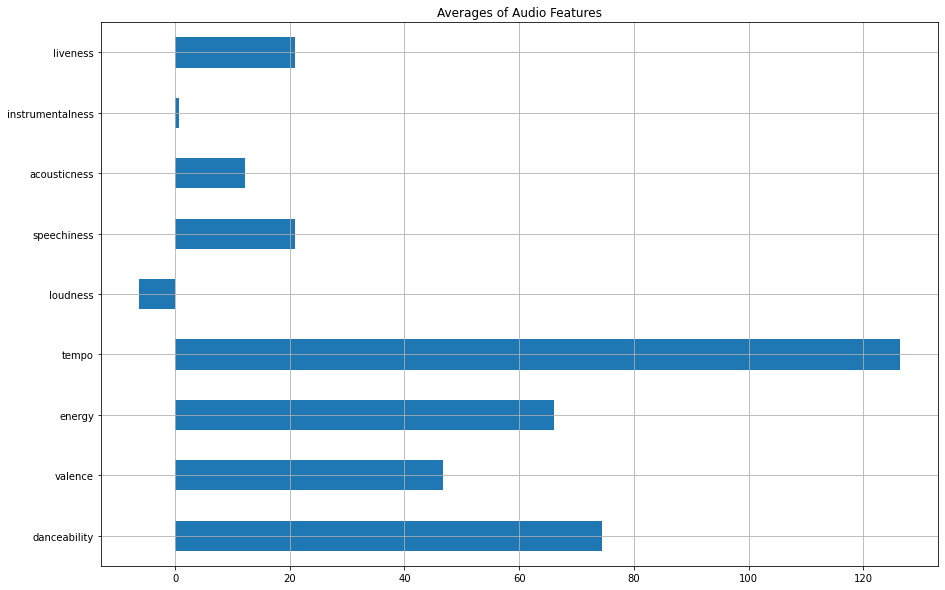

In [19]:
# also plotting the avg values of these features for visibility

df.mean().plot(kind='barh', figsize=(15,10), grid=True, 
              title="Averages of Audio Features" )

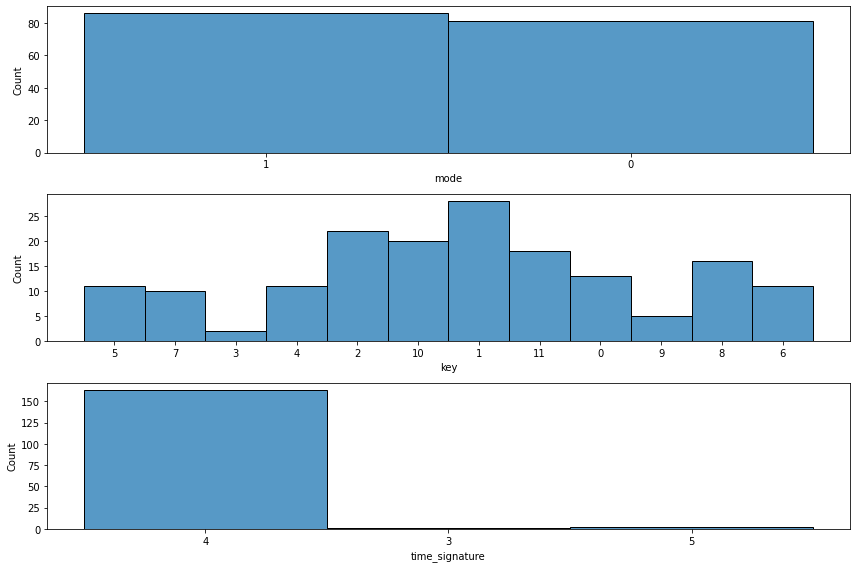

In [20]:
# let's move to the categorical features

cat_audio_feature_df = tracks_selected_playlists_df.loc[:,['mode','key','time_signature']]

for col in cat_audio_feature_df.columns.values.tolist():
    cat_audio_feature_df[col] =  cat_audio_feature_df[col].apply(lambda x:str(x)) 

fig, axs = plt.subplots(3,figsize=(12,8))

sns.histplot(data=cat_audio_feature_df, x='mode',ax=axs[0])
sns.histplot(data=cat_audio_feature_df, x='key',ax=axs[1])
sns.histplot(data=cat_audio_feature_df, x='time_signature',ax=axs[2])

fig.tight_layout()

Conclusion: After reading the descriptions of these 3 features, I don't think they will add a lot of value to this study. Therefore, we will focus on the first batch of the audio features that are all continuous values.

# 1st ML Technique to Filter the Tracks: Cosine Similarity Score

This article explains different metrics to evaluate similarity. In this experiment, we are going to use Cosine Similarity Score.

https://towardsdatascience.com/calculate-similarity-the-most-relevant-metrics-in-a-nutshell-9a43564f533e

Essentially, what we are going to do are as follows:
   - Scale the features to be in the similar range
   - Calculate cosine similarity score for every track in the base df and every track of the recommended df
   - Select the recommended track with the largest similarity score of every track in the base df

In [21]:
scaler = MinMaxScaler()
final_features = audio_features[0:9]

In [22]:
def get_filtered_df_from_sim_score(base_df, rec_df, scaler, features, n_picks:int):
    """
    this funciton is used to calculate cosine similarity scores of each track in the selected playlist(s)
    and each Spotify recommended track
    ---
    parameters
    ---
    base_df: selected playlist(s) in my Spotify libaray
    rec_df: Spotify recommended tracks
    scaler: Scaler used to preprocess data
    features: relevant track audio features
    return: DataFrame that contains the top n most similar tracks to the tracks in the playlist(s)
    """

    base_df[final_features]= scaler.fit_transform(base_df[final_features])
    rec_df[final_features]= scaler.fit_transform(rec_df[final_features])

    new_df_base = base_df.loc[:,final_features]
    new_df_rec = rec_df.loc[:,final_features]

    assert list(new_df_base.columns) == list(new_df_rec.columns)

    sim_score_matrix = cosine_similarity(new_df_base, new_df_rec)

    sim_score_df = pd.DataFrame(sim_score_matrix)
    
    results = np.argsort(-sim_score_df.values,axis=1)[:,0:n_picks]
    
    top_5_list = []
    for i in range(0,results.shape[0]):
        for idx in range(0,len(results[i])):
            top_5_list.append(results[i][idx])

    filtered_df = rec_df.iloc[top_5_list,:].drop_duplicates(ignore_index=True)
    
    return filtered_df

In [23]:
filtered_rec_df = get_filtered_df_from_sim_score(tracks_selected_playlists_df,tracks_recommended_df,scaler,final_features,3)
filtered_rec_df.head()

,id,name,popularity,explicit,artist_id,artist_name,album_release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genres,release_days_diff
0,0LFcFGLYTX6UmeIdO7NVd7,Ali Bomaye,66,1,0NbfKEOTQCcwd6o7wSDOHI,The Game,2012-01-01 00:00:00,0.180939,0.624694,10,0.729931,0,0.467173,0.024092,0.000000,0.442427,0.197445,0.132260,4,"['gangster rap', 'hip hop', 'pop rap', 'rap', ...",3511
1,7sjwaBQ6M3aVigYfBjm1sL,Ima Boss (feat. Rick Ross),66,1,20sxb77xiYeusSH8cVdatc,Meek Mill,2011-05-23 00:00:00,0.165746,0.844743,5,0.888517,1,0.267499,0.047881,0.000000,0.619739,0.312400,0.136584,4,"['hip hop', 'philly rap', 'pop rap', 'rap', 's...",3734
2,2sYUGgzQfHQ6lOWzbrny8Z,Red Nation,62,1,0NbfKEOTQCcwd6o7wSDOHI,The Game,2011-01-01 00:00:00,0.214088,0.867971,2,0.828813,1,0.317417,0.106428,0.000000,0.450972,0.319851,0.155976,4,"['gangster rap', 'hip hop', 'pop rap', 'rap', ...",3876
3,0mCiEhtdRn5YYhefLXcxI7,Narrow Road (feat. Lil Baby),62,1,0ErzCpIMyLcjPiwT4elrtZ,NLE Choppa,2020-08-10 00:00:00,0.502762,0.457213,7,0.586553,1,0.156810,0.035294,0.000000,0.191412,0.131453,0.546669,4,['memphis hip hop'],367
4,1v7L65Lzy0j0vdpRjJewt1,"Lose Yourself - From ""8 Mile"" Soundtrack",75,1,7dGJo4pcD2V6oG8kP0tJRR,Eminem,2004-01-01 00:00:00,0.602210,0.679707,2,0.764188,1,0.259902,0.010593,0.000692,0.339885,0.023523,0.604228,4,"['detroit hip hop', 'hip hop', 'rap']",6433


In [24]:
def filter_with_mean_song(features,num_picks:int,scaler,base_df,filtered_df):
    """
    this funciton is find the top n tracks that are most similar to the mean song in the selected playlist(s)
    ---
    parameters
    ---
    base_df: selected playlist(s) in my Spotify libaray
    filtered_df: DataFrame that contains the most similar tracks to the tracks in the playlist(s)
    scaler: Scaler used to preprocess data
    features: relevant track audio features
    return: DataFrame that contains the top n similar tracks to the mean song
    """

    col_dict = {0:'danceability', 1:'valence', 2:'energy', 3:'tempo', 4:'loudness', 5:"speechiness",\
                6:"acousticness", 7:"instrumentalness", 8:"liveness"}

    mean_song = base_df[features]
    mean_song = pd.DataFrame(scaler.fit_transform(mean_song)).rename(columns=col_dict)
    mean_df = pd.DataFrame(mean_song.mean()).T

    rec_df_2 = filtered_df[features]

    sim_score = cosine_similarity(mean_df, rec_df_2)

    sim_score_df = pd.DataFrame(sim_score)

    results = np.argsort(-sim_score_df.values,axis=1)[:,0:num_picks]

    picks = []
    for i in range(0,len(results[0])):
        picks.append(results[0][i])

    filtered_df_2 = filtered_df.iloc[picks,:].drop_duplicates()

    return filtered_df_2, picks

In [25]:
filtered_df_2,picks_sim_score = filter_with_mean_song(final_features,50,\
                                                      scaler,tracks_selected_playlists_df,filtered_rec_df)
filtered_df_2.head()

,id,name,popularity,explicit,artist_id,artist_name,album_release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genres,release_days_diff
79,1K5KBOgreBi5fkEHvg5ap3,Life Is Good (feat. Drake),74,1,1RyvyyTE3xzB2ZywiAwp0i,Future,2020-05-15 00:00:00,0.752762,0.482885,2,0.651622,0,0.501899,0.077328,0.000000,0.134800,0.531666,0.455708,4,"['atl hip hop', 'pop rap', 'rap', 'southern hi...",454
288,56uXDJRCuoS7abX3SkzHKQ,Myron,76,1,4O15NlyKLIASxsJ0PrXPfz,Lil Uzi Vert,2020-03-13 00:00:00,0.719613,0.580685,8,0.648029,0,0.296799,0.063470,0.000000,0.203162,0.569984,0.521569,4,"['melodic rap', 'philly rap', 'rap', 'trap']",517
109,4XQnZMnNPqpPKfzpQi6ysN,New Gucci Garment (feat. Xanman),7,0,5kEIoxHSPy9qHJqgR2Ng5Z,Black Fortune,2021-04-09 00:00:00,0.578729,0.486553,9,0.563420,1,0.423766,0.148924,0.000000,0.062166,0.465673,0.450229,4,"['dmv rap', 'vapor trap']",125
50,0xf5EE2taRxE3lDBV8IXMR,Wonderland (feat. M Huncho),67,1,3iAhNz3e31lBuXYOsqGsf3,Unknown T,2021-06-10 00:00:00,0.483425,0.440098,6,0.544027,0,0.338036,0.035640,0.000463,0.136937,0.374135,0.444141,4,"['uk alternative hip hop', 'uk drill', 'uk hip...",63
130,120yTRp3pAS5xgiXGpSGkd,Love... (Her Fault) [feat. Bryson Tiller],51,0,67nwj3Y5sZQLl72VNUHEYE,Wale,2019-10-10 00:00:00,0.716851,0.503667,0,0.629325,1,0.521432,0.099269,0.000000,0.102756,0.401809,0.526456,4,"['dance pop', 'gangster rap', 'hip hop', 'pop'...",672


<AxesSubplot:title={'center':'Averages of Audio Features(filtered by Cosine Sim Score)'}>

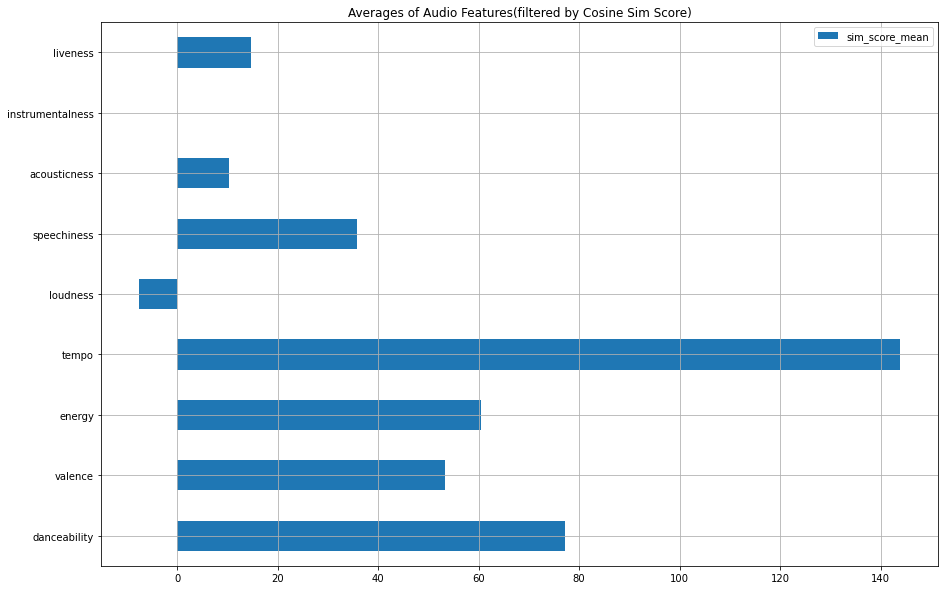

In [26]:
# plot the averages of the final filtered df

df_2 = initial_rec_tracks_df.copy()
df_2 = df_2[df_2['id'].isin(filtered_df_2['id'])].reset_index()

for feature in df_2[final_features].columns:
    if feature == 'tempo' or feature == 'loudness':
        continue
    df_2[feature] = df_2[feature] * 100

sim_score_mean = pd.DataFrame(df_2[final_features].mean()).rename(columns={0:'sim_score_mean'})

sim_score_mean.plot(kind='barh', figsize=(15,10), grid=True, 
              title="Averages of Audio Features(filtered by Cosine Sim Score)" )


Comparing the averages of the audio features of the filtered tracks to those of the selected playlist, we see that the values are pretty similar, which means that we successfully pick the tracks that close to the tracks in the playlist that we like.

# 2nd ML Technique to filter the tracks: KNN Algorithm

Next, I am going to try the KNN algorithm. Firstly, we need to merge the selected playlist df and the recommneded tracks df. Then we will run the algorithm to find the 5 nearest neighbors of each track in the selected playlist.

In [27]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [28]:
n_count = 5
knn_5 = NearestNeighbors(n_neighbors=n_count, metric='cosine', n_jobs=-1)

In [29]:
new_selected_playlist = followed_playlists_df.copy()
new_spotify_rec_df = initial_rec_tracks_df.copy()

In [30]:
def KNearestNeighbor_filtering(base_df,rec_df,features,scaler,model,n_count):

    # let's merge the 2 DataFrames first
    merged_df = base_df.append(rec_df,ignore_index=True)
    merged_df[final_features]= scaler.fit_transform(merged_df[final_features])
    
    knn_features = features.copy()
    knn_features.insert(0,"id")
    merged_df = merged_df[knn_features]
    
    # create a dict for index and track id mapping
    track_dict = dict()
    for index,track in zip(merged_df.index, merged_df['id']):
        track_dict.update({index:track})

    fit_df = merged_df.drop(columns='id')
    
    # convert dataframe of movie features to scipy sparse matrix
    mat_track_features = csr_matrix(fit_df.values)
    
    # run the KNN model
    
    model.fit(mat_track_features)
    idx = merged_df.index[0:base_df.shape[0]]
    distances, indices = model.kneighbors(mat_track_features[0:base_df.shape[0]],n_neighbors=n_count+1)
    
    # get the n nearest items from the KNN model
    knn_picks = []
    for idx in range(0,indices.shape[0]):
        for item in range(0,n_count+1):
            if item == 0:
                continue
            knn_picks.append(track_dict[indices[idx][item]])
            
    chosen_tracks_df = rec_df[rec_df['id'].isin(knn_picks)].drop_duplicates(ignore_index=True)
    
    return chosen_tracks_df

In [31]:
knn_picks_df = KNearestNeighbor_filtering(new_selected_playlist,\
                                        new_spotify_rec_df,final_features,scaler,knn_5,n_count)
knn_picks_df.head()

,id,name,popularity,type_x,is_local,explicit,duration_ms_x,disc_number,track_number,artist_id,artist_name,album_artist_id,album_artist_name,album_id,album_name,album_release_date,album_type,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type_y,uri,track_href,analysis_url,duration_ms_y,time_signature,genres,album_genres
0,5YEOzOojehCqxGQCcQiyR4,Panda,73,track,False,True,246761,1,14,7pFeBzX627ff0VnN6bxPR4,Desiigner,7pFeBzX627ff0VnN6bxPR4,Desiigner,0cHT4ll3sEPyFFWoFuibMl,New English,2016-06-26,ALBUM,0.576,0.766,10,-4.943,0,0.449,0.02800,0.000002,0.366,0.236,144.833,audio_features,spotify:track:5YEOzOojehCqxGQCcQiyR4,https://api.spotify.com/v1/tracks/5YEOzOojehCq...,https://api.spotify.com/v1/audio-analysis/5YEO...,246761,4,"['pop rap', 'rap', 'trap', 'viral trap']","['pop rap', 'rap', 'trap', 'viral trap']"
1,1BvTqJLeB9ZeGU01gFzJbh,"Bag of Money (feat. Rick Ross, Meek Mill & T-P...",45,track,False,True,247293,1,1,67nwj3Y5sZQLl72VNUHEYE,Wale,67nwj3Y5sZQLl72VNUHEYE,Wale,4M1WXCpnNqFMmiZz0W3FfW,"Bag of Money (feat. Rick Ross, Meek Mill & T-P...",2012-03-23,SINGLE,0.536,0.560,8,-5.668,1,0.260,0.03790,0.000000,0.114,0.279,139.910,audio_features,spotify:track:1BvTqJLeB9ZeGU01gFzJbh,https://api.spotify.com/v1/tracks/1BvTqJLeB9Ze...,https://api.spotify.com/v1/audio-analysis/1BvT...,247293,4,"['dance pop', 'gangster rap', 'hip hop', 'pop'...","['dance pop', 'gangster rap', 'hip hop', 'pop'..."
2,2JvzF1RMd7lE3KmFlsyZD8,MIDDLE CHILD,79,track,False,True,213593,1,1,6l3HvQ5sa6mXTsMTB19rO5,J. Cole,6l3HvQ5sa6mXTsMTB19rO5,J. Cole,3XzSOIE6zGLliuqsVGLmUc,MIDDLE CHILD,2019-01-23,SINGLE,0.837,0.364,8,-11.713,1,0.276,0.14900,0.000000,0.271,0.463,123.984,audio_features,spotify:track:2JvzF1RMd7lE3KmFlsyZD8,https://api.spotify.com/v1/tracks/2JvzF1RMd7lE...,https://api.spotify.com/v1/audio-analysis/2Jvz...,213594,4,"['conscious hip hop', 'hip hop', 'north caroli...","['conscious hip hop', 'hip hop', 'north caroli..."
3,2NRUU0gP1d8Yif8CpsCW8l,Faded,59,track,False,True,206666,1,10,5LHRHt1k9lMyONurDHEdrp,Tyga,5LHRHt1k9lMyONurDHEdrp,Tyga,3KHamR7LZmFT0xqPA1Hyob,Careless World: Rise Of The Last King,2012-01-01,ALBUM,0.831,0.667,1,-8.438,1,0.188,0.01030,0.000000,0.350,0.339,95.073,audio_features,spotify:track:2NRUU0gP1d8Yif8CpsCW8l,https://api.spotify.com/v1/tracks/2NRUU0gP1d8Y...,https://api.spotify.com/v1/audio-analysis/2NRU...,206667,4,"['dance pop', 'hip hop', 'pop rap', 'rap', 'so...","['dance pop', 'hip hop', 'pop rap', 'rap', 'so..."
4,1rX5L6pyl3rVWb55D8Cprr,Gold Roses (feat. Drake),66,track,False,True,349600,1,15,1sBkRIssrMs1AbVkOJbc7a,Rick Ross,1sBkRIssrMs1AbVkOJbc7a,Rick Ross,1mgw5rbUS94uif2ce9QCf0,Port of Miami 2,2019-08-15,ALBUM,0.502,0.633,1,-5.800,1,0.419,0.00991,0.000000,0.389,0.552,83.226,audio_features,spotify:track:1rX5L6pyl3rVWb55D8Cprr,https://api.spotify.com/v1/tracks/1rX5L6pyl3rV...,https://api.spotify.com/v1/audio-analysis/1rX5...,349600,4,"['dirty south rap', 'gangster rap', 'hip hop',...","['dirty south rap', 'gangster rap', 'hip hop',..."


In [32]:
filtered_df_knn,picks_knn = filter_with_mean_song(final_features,50,scaler,\
                                                  tracks_selected_playlists_df,knn_picks_df)

df_3 = initial_rec_tracks_df.copy()
df_3 = df_3[df_3['id'].isin(filtered_df_knn['id'])].reset_index()

for feature in df_3[final_features].columns:
    if feature == 'tempo' or feature == 'loudness':
        continue
    df_3[feature] = df_3[feature] * 100

df_3[final_features].mean()

# plot(kind='barh', figsize=(15,10), grid=True, 
#               title="Averages of Audio Features(filtered by KNN)" )

danceability         70.648000
valence              58.035000
energy               83.818000
tempo               132.703340
loudness             -2.995680
speechiness          21.073200
acousticness         11.233154
instrumentalness      0.092496
liveness             24.343600
dtype: float64

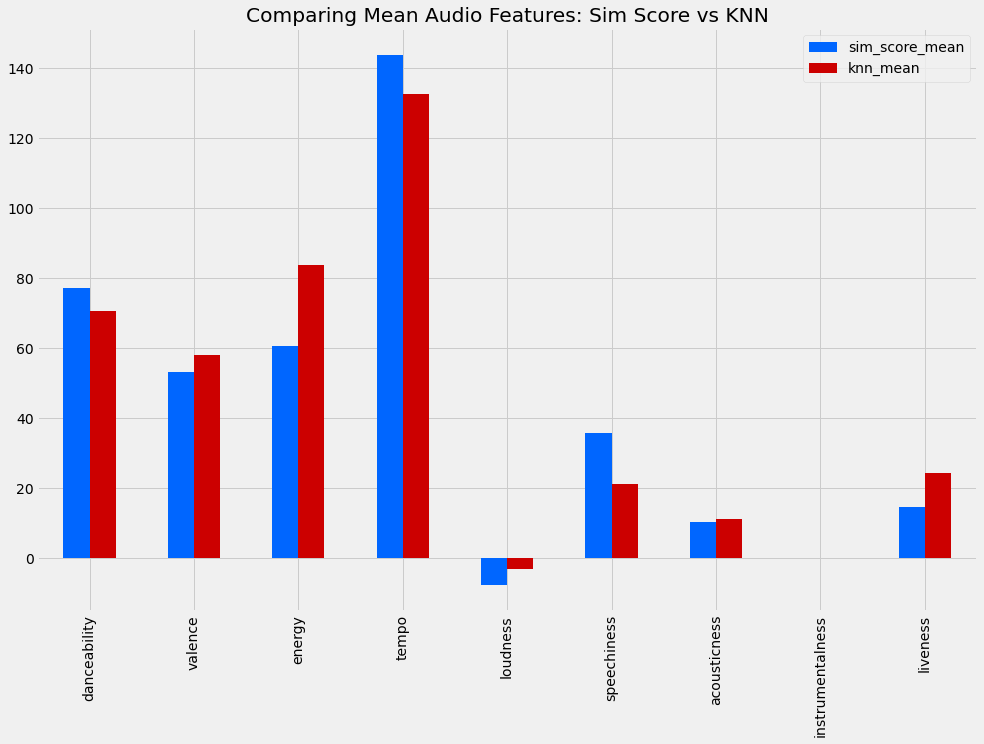

In [33]:
# join the 2 mean dfs and plot the means side by side
knn_mean_df = pd.DataFrame(df_3[final_features].mean()).rename(columns={0:'knn_mean'})
mean_compare_df = sim_score_mean.join(knn_mean_df,on=sim_score_mean.index)

plt.style.use('fivethirtyeight')
mean_compare_df.plot.bar(color = ['#0066FF', '#CC0000'], figsize = (15,10))
plt.title('Comparing Mean Audio Features: Sim Score vs KNN')
plt.legend(loc = 'upper right')
plt.show()

KNN algorithm and Cosine Similarity Score yield similar results.

In [59]:
overlap = pd.Series(list(set(df_2['name']).intersection(set(df_3['name']))))

if overlap.shape[0] == 0:
    print("There is no overlapping in the outputs of the 2 algorithms.")
    print("---"*20)
else:
    print("Below is the list of the overlapping values in the outputs of 2 ML models")
    print("---"*20)
    print(overlap)
    print("---"*20)
    print('Overlapping rate:',(overlap.shape[0]/df_2.shape[0])*100,"%")
    print("---"*20)
    print("Below are the unique songs in the Sim Score technique recommendations ")


print("Below are the unique songs in the Similarity Score algorithm recommendations ")
sim_score_unique = df_2[~df_2['name'].isin(df_3['name'])]
print(sim_score_unique['name'])
print("---"*20)
print("Below are the unique songs in the KNN algorithm recommendations ")
print("-"*20)
knn5_unique = df_3[~df_3['name'].isin(df_2['name'])]
print(knn5_unique['name'])

There is no overlapping in the outputs of the 2 algorithms.
------------------------------------------------------------
Below are the unique songs in the Similarity Score algorithm recommendations 
0                                       TAKE IT
1                                       Bundles
2                      Cash Shit (feat. DaBaby)
3                                  Rip Lil Peep
4              New Gucci Garment (feat. Xanman)
5                                Ya Nuh - Remix
6                   Wonderland (feat. M Huncho)
7                                         I Sip
8                                         Myron
9                                       Hitterz
10                               Picture Frames
11                              Substance Abuse
12                                      The One
13                            Took Her To The O
14                                 Back On Road
15               Still Trappin' (with King Von)
16      BANKROLL (feat. A$AP Rock

/Users/Lawrence/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


# Last step: Feed the filtered tracks back to my Spotify library

In [55]:
import spotipy
import spotipy.util as util

In [37]:
# using scopes
scope = "playlist-modify-public playlist-modify-private"

In [38]:
# Authorization flow
token = util.prompt_for_user_token(user_name, scope, client_id=c_id, \
                                   client_secret=secret,show_dialog=True, redirect_uri=uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", user_name)

In [63]:
# becareful the first argument of the user playlist create function should be your user name
boxing_playlist_sim_score = sp.user_playlist_create(user_name, "sim score recommendations",description="Spotify recommendations filtered by similarify score")
boxing_playlist_knn = sp.user_playlist_create(user_name, "boxing_playlist_knn",description="Spotify recommendations filtered by similarify score")

In [64]:
begin_time = datetime.now()

sp.user_playlist_add_tracks(user=user_name, 
                        playlist_id=boxing_playlist_sim_score['id'], 
                        tracks=df_2['id'].tolist())
sp.user_playlist_add_tracks(user=user_name, 
                    playlist_id=boxing_playlist_knn['id'], 
                    tracks=knn5_unique['id'].to_list())

end_time = datetime.now()

time_diff_seconds = (end_time - begin_time).total_seconds()

print('It has taken',time_diff_seconds,'seconds to add the filtered recommended tracks to my Spotify!')

It has taken 0.261001 seconds to add the filtered recommended tracks to my Spotify!
